In [1]:
import os, datetime
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, LearningRateScheduler

import sklearn
from sklearn import metrics
from sklearn.metrics import confusion_matrix

import itertools

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

Num GPUs Available:  1


In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
tf.__version__

'2.4.1'

In [5]:
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [6]:
import utils
from utils import *

In [7]:
curTime()

Current Time = 23:04:30


datetime.datetime(2021, 4, 11, 23, 4, 30, 947387)

In [8]:
def create_model_NasNetL(number_classes, optimizer, metrics,input_shape=(331,331,3)):
    
    base_model = keras.applications.NASNetLarge(
        weights='imagenet',
        input_shape=input_shape,
        include_top=False)
    base_model.trainable = False
    
    inputs = keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    #x = keras.layers.Flatten()(x)
    outputs = keras.layers.Dense(number_classes)(x)
    model = keras.Model(inputs, outputs)
    
    model.compile(optimizer=optimizer,
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=metrics)
    return model

In [9]:
def create_model_NasNetM(number_classes, optimizer, metrics,input_shape=(224,224,3)):
    
    base_model = keras.applications.NASNetMobile(
        weights='imagenet',
        input_shape=input_shape,
        include_top=False)
    base_model.trainable = False
    
    inputs = keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    #x = keras.layers.Flatten()(x)
    outputs = keras.layers.Dense(number_classes)(x)
    model = keras.Model(inputs, outputs)
    
    model.compile(optimizer=optimizer,
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=metrics)
    return model

In [10]:
es = EarlyStopping(monitor='val_loss', patience=10, mode='min', min_delta=0.01, verbose=1)

In [11]:
# CONSTANTS
in_shape_L = (331, 331, 3)
in_shape_M = (224, 224, 3)
INPUT_SIZE_L = 331
INPUT_SIZE_M = 224

train_dir = './cats/v4/train'
test_dir = './cats/v4/test'
breeds = os.listdir(train_dir)
no_classes = len(breeds)
no_classes

10

In [12]:
optimizer = keras.optimizers.Adamax()
metrics=[keras.metrics.CategoricalAccuracy()]

***

### LArge


In [28]:
augs = ''

In [19]:
data_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.nasnet.preprocess_input, validation_split=0.3)
train_batches = data_gen.flow_from_directory(directory=train_dir, target_size=(INPUT_SIZE_L,INPUT_SIZE_L), classes=breeds, batch_size=64, subset="training") 
valid_batches = data_gen.flow_from_directory(directory=train_dir, target_size=(INPUT_SIZE_L,INPUT_SIZE_L), classes=breeds, batch_size=64, subset="validation")
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.nasnet.preprocess_input).flow_from_directory(directory=test_dir, target_size=(INPUT_SIZE_L,INPUT_SIZE_L), classes=breeds, batch_size=10, shuffle=False)

Found 18584 images belonging to 10 classes.
Found 7956 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [20]:
log_dir=os.path.join('logs','fitnl',curTime().strftime("%Y%m%d-%H%M%S"))

Current Time = 23:06:21


In [21]:
tb =  TensorBoard(log_dir=log_dir, histogram_freq=1,profile_batch = '500,520')

In [22]:
cbks=[tb,es]

In [23]:
nl1 = create_model_NasNetL(number_classes=no_classes, optimizer=optimizer, metrics=metrics)
nl1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 331, 331, 3)]     0         
_________________________________________________________________
NASNet (Functional)          (None, 11, 11, 4032)      84916818  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 4032)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                40330     
Total params: 84,957,148
Trainable params: 40,330
Non-trainable params: 84,916,818
_________________________________________________________________


In [24]:
h_nl1 = nl1.fit(train_batches,epochs=100, callbacks=cbks,validation_data=valid_batches)

Epoch 1/100
291/291 [==============================] - 900s 3s/step - loss: 1.3529 - categorical_accuracy: 0.5631 - val_loss: 0.9576 - val_categorical_accuracy: 0.6948
Epoch 2/100
291/291 [==============================] - 817s 3s/step - loss: 0.8710 - categorical_accuracy: 0.7184 - val_loss: 0.8685 - val_categorical_accuracy: 0.7212
Epoch 3/100
291/291 [==============================] - 802s 3s/step - loss: 0.7796 - categorical_accuracy: 0.7474 - val_loss: 0.8334 - val_categorical_accuracy: 0.7359
Epoch 4/100
291/291 [==============================] - 790s 3s/step - loss: 0.7337 - categorical_accuracy: 0.7650 - val_loss: 0.8123 - val_categorical_accuracy: 0.7398
Epoch 5/100
291/291 [==============================] - 771s 3s/step - loss: 0.7139 - categorical_accuracy: 0.7688 - val_loss: 0.7869 - val_categorical_accuracy: 0.7459
Epoch 6/100
291/291 [==============================] - 775s 3s/step - loss: 0.6858 - categorical_accuracy: 0.7785 - val_loss: 0.7785 - val_categorical_accuracy:

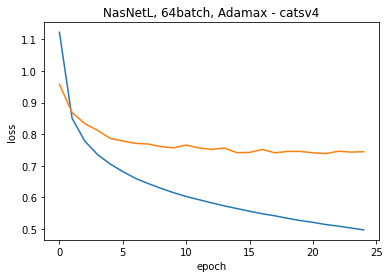

In [25]:
plotLoss('NasNetL, 64batch, Adamax - catsv4', h_nl1)

In [26]:
pred_nl1 = nl1.predict(x=test_batches, steps=len(test_batches), verbose=1)

100/100 [==============================] - 53s 408ms/step


Confusion matrix, without normalization
[[85  1  0  2  1  0  0  1  7  3]
 [ 0 68  1  1  0  3  0  5 14  8]
 [ 1  1 92  1  1  0  0  3  1  0]
 [ 0  4  0 68 13  7  0  3  1  4]
 [ 0  1  0  7 75  8  0  7  0  2]
 [ 1  0  4  8 17 67  0  1  0  2]
 [ 0  4  1  2  5  1 82  2  2  1]
 [ 1  6  4  3  1  0  0 84  1  0]
 [ 3  6  0  0  0  1  0  2 86  2]
 [ 3  3  0  1  0  1  0  2  1 89]]


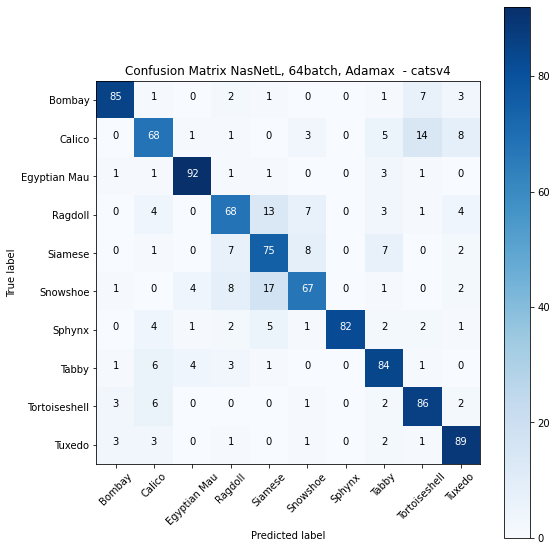

In [29]:
displayCM(y_true=test_batches.classes, predictions=pred_nl1, plot_labels=breeds, title=f'Confusion Matrix NasNetL, 64batch, Adamax {augs} - catsv4')

* adding horizontal flip and rotation: worse
* adding shear: even worse
* rotation flip brightness: not much worse? maybe brightness is good

***

In [30]:
augs = 'rotation flip'

In [31]:
data_gen = ImageDataGenerator(horizontal_flip=True, rotation_range=90, preprocessing_function=tf.keras.applications.nasnet.preprocess_input, validation_split=0.3)
train_batches = data_gen.flow_from_directory(directory=train_dir, target_size=(INPUT_SIZE_L,INPUT_SIZE_L), classes=breeds, batch_size=64, subset="training") 
valid_batches = data_gen.flow_from_directory(directory=train_dir, target_size=(INPUT_SIZE_L,INPUT_SIZE_L), classes=breeds, batch_size=64, subset="validation")
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.nasnet.preprocess_input).flow_from_directory(directory=test_dir, target_size=(INPUT_SIZE_L,INPUT_SIZE_L), classes=breeds, batch_size=10, shuffle=False)

Found 18584 images belonging to 10 classes.
Found 7956 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [32]:
log_dir=os.path.join('logs','fitnl',curTime().strftime("%Y%m%d-%H%M%S"))

Current Time = 09:47:19


In [33]:
tb =  TensorBoard(log_dir=log_dir, histogram_freq=1,profile_batch = '500,520')

In [34]:
cbks=[tb,es]

In [35]:
nl2 = create_model_NasNetL(number_classes=no_classes, optimizer=optimizer, metrics=metrics)

In [36]:
h_nl2 = nl2.fit(train_batches,epochs=100, callbacks=cbks,validation_data=valid_batches)

Epoch 1/100
291/291 [==============================] - 1263s 4s/step - loss: 1.5150 - categorical_accuracy: 0.6469 - val_loss: 1.0043 - val_categorical_accuracy: 0.6758
Epoch 2/100
291/291 [==============================] - 940s 3s/step - loss: 0.9377 - categorical_accuracy: 0.6985 - val_loss: 0.9115 - val_categorical_accuracy: 0.7078
Epoch 3/100
291/291 [==============================] - 933s 3s/step - loss: 0.8548 - categorical_accuracy: 0.7155 - val_loss: 0.8807 - val_categorical_accuracy: 0.7156
Epoch 4/100
291/291 [==============================] - 922s 3s/step - loss: 0.8138 - categorical_accuracy: 0.7314 - val_loss: 0.8467 - val_categorical_accuracy: 0.7198
Epoch 5/100
291/291 [==============================] - 896s 3s/step - loss: 0.7942 - categorical_accuracy: 0.7342 - val_loss: 0.8445 - val_categorical_accuracy: 0.7247
Epoch 6/100
291/291 [==============================] - 909s 3s/step - loss: 0.7662 - categorical_accuracy: 0.7478 - val_loss: 0.8347 - val_categorical_accuracy

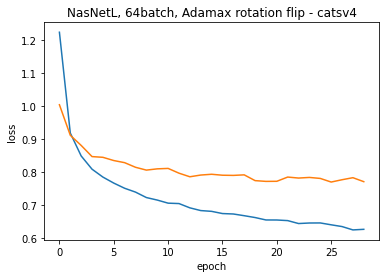

In [37]:
plotLoss(f'NasNetL, 64batch, Adamax {augs} - catsv4', h_nl2)

In [38]:
pred_nl2 = nl2.predict(x=test_batches, steps=len(test_batches), verbose=1)

100/100 [==============================] - 46s 399ms/step


Confusion matrix, without normalization
[[85  3  0  1  1  0  0  0  7  3]
 [ 0 65  0  1  3  3  0  7 17  4]
 [ 1  0 94  1  0  1  0  2  1  0]
 [ 0  3  0 60 23  6  0  3  2  3]
 [ 0  1  1  3 80  7  0  6  0  2]
 [ 1  0  5  7 24 60  0  1  0  2]
 [ 0  1  1  2  7  2 82  1  2  2]
 [ 1  6  4  2  1  0  0 86  0  0]
 [ 4 12  0  0  1  0  0  2 80  1]
 [ 8  4  0  1  0  0  0  2  1 84]]


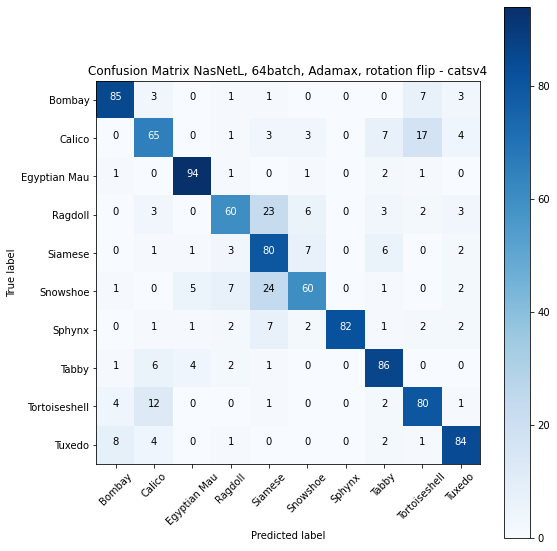

In [40]:
displayCM(y_true=test_batches.classes, predictions=pred_nl2, plot_labels=breeds, title=f'Confusion Matrix NasNetL, 64batch, Adamax, {augs} - catsv4')

***

In [41]:
augs = 'shear'

In [42]:
data_gen = ImageDataGenerator(shear_range=40,preprocessing_function=tf.keras.applications.nasnet.preprocess_input, validation_split=0.3)
train_batches = data_gen.flow_from_directory(directory=train_dir, target_size=(INPUT_SIZE_L,INPUT_SIZE_L), classes=breeds, batch_size=64, subset="training") 
valid_batches = data_gen.flow_from_directory(directory=train_dir, target_size=(INPUT_SIZE_L,INPUT_SIZE_L), classes=breeds, batch_size=64, subset="validation")
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.nasnet.preprocess_input).flow_from_directory(directory=test_dir, target_size=(INPUT_SIZE_L,INPUT_SIZE_L), classes=breeds, batch_size=10, shuffle=False)

Found 18584 images belonging to 10 classes.
Found 7956 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [43]:
log_dir=os.path.join('logs','fitnl',curTime().strftime("%Y%m%d-%H%M%S"))

Current Time = 18:37:43


In [44]:
tb =  TensorBoard(log_dir=log_dir, histogram_freq=1,profile_batch = '500,520')

In [45]:
cbks=[tb,es]

In [46]:
nl3 = create_model_NasNetL(number_classes=no_classes, optimizer=optimizer, metrics=metrics)

In [47]:
h_nl3 = nl3.fit(train_batches,epochs=100, callbacks=cbks,validation_data=valid_batches)

Epoch 1/100
291/291 [==============================] - 1370s 5s/step - loss: 1.5147 - categorical_accuracy: 0.6470 - val_loss: 1.0054 - val_categorical_accuracy: 0.6712
Epoch 2/100
291/291 [==============================] - 1215s 4s/step - loss: 0.9367 - categorical_accuracy: 0.6978 - val_loss: 0.9204 - val_categorical_accuracy: 0.7011
Epoch 3/100
291/291 [==============================] - 1142s 4s/step - loss: 0.8564 - categorical_accuracy: 0.7174 - val_loss: 0.8611 - val_categorical_accuracy: 0.7210
Epoch 4/100
291/291 [==============================] - 1008s 3s/step - loss: 0.8122 - categorical_accuracy: 0.7351 - val_loss: 0.8435 - val_categorical_accuracy: 0.7269
Epoch 5/100
291/291 [==============================] - 978s 3s/step - loss: 0.7956 - categorical_accuracy: 0.7331 - val_loss: 0.8266 - val_categorical_accuracy: 0.7265
Epoch 6/100
291/291 [==============================] - 961s 3s/step - loss: 0.7460 - categorical_accuracy: 0.7567 - val_loss: 0.8155 - val_categorical_accur

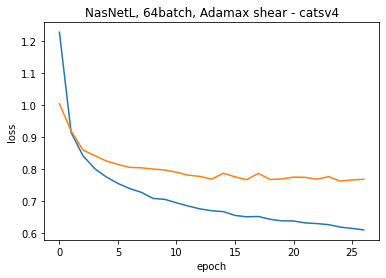

In [48]:
plotLoss(f'NasNetL, 64batch, Adamax {augs} - catsv4', h_nl3)

In [49]:
pred_nl3 = nl3.predict(x=test_batches, steps=len(test_batches), verbose=1)

100/100 [==============================] - 48s 404ms/step


Confusion matrix, without normalization
[[84  2  0  1  1  0  0  1  8  3]
 [ 0 55  2  1  2  6  0  9 17  8]
 [ 1  0 92  1  0  1  0  4  1  0]
 [ 0  1  0 68 17  6  0  5  1  2]
 [ 0  0  0  7 74 10  0  7  0  2]
 [ 1  0  4  9 17 66  0  1  0  2]
 [ 0  1  1  1  4  1 85  3  3  1]
 [ 1  5  4  2  1  0  0 86  1  0]
 [ 3  5  0  0  0  1  0  2 86  3]
 [ 3  3  0  1  0  0  0  3  1 89]]


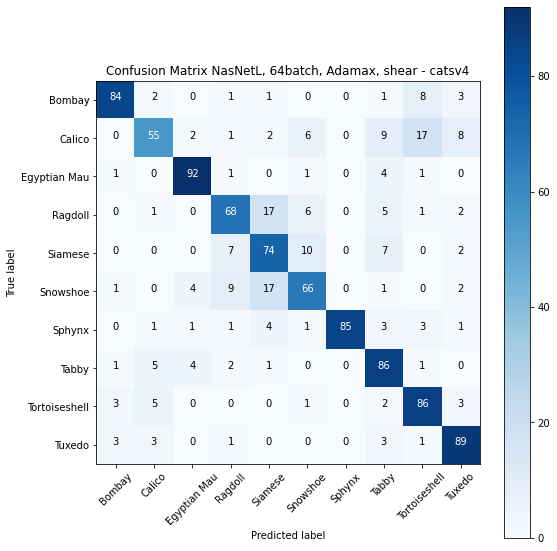

In [50]:
displayCM(y_true=test_batches.classes, predictions=pred_nl3, plot_labels=breeds, title=f'Confusion Matrix NasNetL, 64batch, Adamax, {augs} - catsv4')

***

In [51]:
augs = 'rotation flip brightness'

In [52]:
data_gen = ImageDataGenerator(horizontal_flip=True, rotation_range=90, brightness_range=[0.8,1.2],preprocessing_function=tf.keras.applications.nasnet.preprocess_input, validation_split=0.3)
train_batches = data_gen.flow_from_directory(directory=train_dir, target_size=(INPUT_SIZE_L,INPUT_SIZE_L), classes=breeds, batch_size=64, subset="training") 
valid_batches = data_gen.flow_from_directory(directory=train_dir, target_size=(INPUT_SIZE_L,INPUT_SIZE_L), classes=breeds, batch_size=64, subset="validation")
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.nasnet.preprocess_input).flow_from_directory(directory=test_dir, target_size=(INPUT_SIZE_L,INPUT_SIZE_L), classes=breeds, batch_size=10, shuffle=False)

Found 18584 images belonging to 10 classes.
Found 7956 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [53]:
log_dir=os.path.join('logs','fitnl',curTime().strftime("%Y%m%d-%H%M%S"))

Current Time = 02:14:01


In [54]:
tb =  TensorBoard(log_dir=log_dir, histogram_freq=1,profile_batch = '500,520')

In [55]:
cbks=[tb,es]

In [56]:
nl4 = create_model_NasNetL(number_classes=no_classes, optimizer=optimizer, metrics=metrics)

In [57]:
h_nl4 = nl4.fit(train_batches,epochs=100, callbacks=cbks,validation_data=valid_batches)

Epoch 1/100
291/291 [==============================] - 1097s 4s/step - loss: 1.5242 - categorical_accuracy: 0.6351 - val_loss: 1.0168 - val_categorical_accuracy: 0.6650
Epoch 2/100
291/291 [==============================] - 1067s 4s/step - loss: 0.9417 - categorical_accuracy: 0.6874 - val_loss: 0.9199 - val_categorical_accuracy: 0.7036
Epoch 3/100
291/291 [==============================] - 1018s 3s/step - loss: 0.8738 - categorical_accuracy: 0.7081 - val_loss: 0.8793 - val_categorical_accuracy: 0.7071
Epoch 4/100
291/291 [==============================] - 994s 3s/step - loss: 0.8162 - categorical_accuracy: 0.7322 - val_loss: 0.8703 - val_categorical_accuracy: 0.7124
Epoch 5/100
291/291 [==============================] - 974s 3s/step - loss: 0.7922 - categorical_accuracy: 0.7387 - val_loss: 0.8427 - val_categorical_accuracy: 0.7239
Epoch 6/100
291/291 [==============================] - 979s 3s/step - loss: 0.7792 - categorical_accuracy: 0.7441 - val_loss: 0.8284 - val_categorical_accura

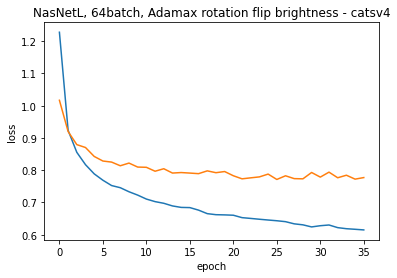

In [58]:
plotLoss(f'NasNetL, 64batch, Adamax {augs} - catsv4', h_nl4)

In [59]:
pred_nl4 = nl4.predict(x=test_batches, steps=len(test_batches), verbose=1)

100/100 [==============================] - 45s 395ms/step


Confusion matrix, without normalization
[[86  2  0  1  1  0  0  1  7  2]
 [ 0 68  0  1  0  6  0  4 16  5]
 [ 1  0 91  1  0  3  0  3  1  0]
 [ 0  4  0 60 17 12  0  3  1  3]
 [ 0  2  0  3 79  8  0  7  0  1]
 [ 1  0  3  6 13 74  0  1  0  2]
 [ 0  1  1  1  4  3 85  2  2  1]
 [ 1  7  4  2  1  0  0 85  0  0]
 [ 3 11  0  0  0  1  0  2 82  1]
 [ 3  4  0  1  0  0  0  2  2 88]]


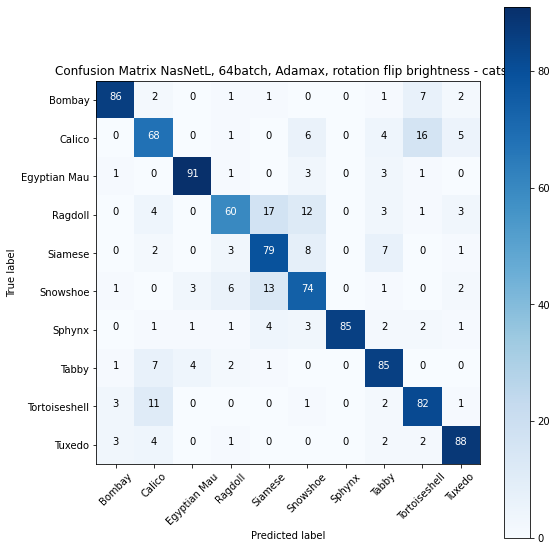

In [60]:
displayCM(y_true=test_batches.classes, predictions=pred_nl4, plot_labels=breeds, title=f'Confusion Matrix NasNetL, 64batch, Adamax, {augs} - catsv4')

***

In [61]:
augs = 'rotation flip brightness shear'

In [62]:
data_gen = ImageDataGenerator(horizontal_flip=True, rotation_range=90, brightness_range=[0.8,1.2],shear_range=40,preprocessing_function=tf.keras.applications.nasnet.preprocess_input, validation_split=0.3)
train_batches = data_gen.flow_from_directory(directory=train_dir, target_size=(INPUT_SIZE_L,INPUT_SIZE_L), classes=breeds, batch_size=64, subset="training") 
valid_batches = data_gen.flow_from_directory(directory=train_dir, target_size=(INPUT_SIZE_L,INPUT_SIZE_L), classes=breeds, batch_size=64, subset="validation")
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.nasnet.preprocess_input).flow_from_directory(directory=test_dir, target_size=(INPUT_SIZE_L,INPUT_SIZE_L), classes=breeds, batch_size=10, shuffle=False)

Found 18584 images belonging to 10 classes.
Found 7956 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [63]:
log_dir=os.path.join('logs','fitnl',curTime().strftime("%Y%m%d-%H%M%S"))

Current Time = 12:29:35


In [64]:
tb =  TensorBoard(log_dir=log_dir, histogram_freq=1,profile_batch = '500,520')

In [65]:
cbks=[tb,es]

In [66]:
nl5 = create_model_NasNetL(number_classes=no_classes, optimizer=optimizer, metrics=metrics)

In [67]:
h_nl5 = nl5.fit(train_batches,epochs=100, callbacks=cbks,validation_data=valid_batches)

Epoch 1/100
291/291 [==============================] - 1184s 4s/step - loss: 1.5626 - categorical_accuracy: 0.6319 - val_loss: 1.0473 - val_categorical_accuracy: 0.6523
Epoch 2/100
291/291 [==============================] - 1192s 4s/step - loss: 0.9748 - categorical_accuracy: 0.6744 - val_loss: 0.9582 - val_categorical_accuracy: 0.6838
Epoch 3/100
291/291 [==============================] - 1160s 4s/step - loss: 0.9059 - categorical_accuracy: 0.7014 - val_loss: 0.9293 - val_categorical_accuracy: 0.6931
Epoch 4/100
291/291 [==============================] - 1260s 4s/step - loss: 0.8620 - categorical_accuracy: 0.7147 - val_loss: 0.9105 - val_categorical_accuracy: 0.7004
Epoch 5/100
291/291 [==============================] - 1219s 4s/step - loss: 0.8455 - categorical_accuracy: 0.7148 - val_loss: 0.8890 - val_categorical_accuracy: 0.7042
Epoch 6/100
291/291 [==============================] - 1120s 4s/step - loss: 0.8450 - categorical_accuracy: 0.7163 - val_loss: 0.8769 - val_categorical_acc

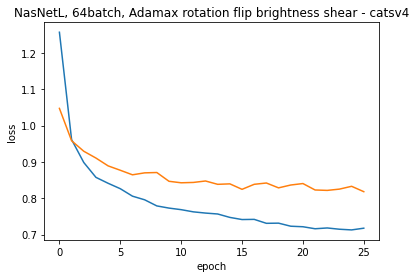

In [68]:
plotLoss(f'NasNetL, 64batch, Adamax {augs} - catsv4', h_nl5)

In [69]:
pred_nl5 = nl5.predict(x=test_batches, steps=len(test_batches), verbose=1)

100/100 [==============================] - 58s 438ms/step


Confusion matrix, without normalization
[[83  2  0  1  1  0  0  0  8  5]
 [ 0 63  0  2  1  5  0  9 16  4]
 [ 1  0 93  2  0  1  0  2  1  0]
 [ 0  4  0 62 17 10  0  3  1  3]
 [ 0  2  1  6 76  7  0  6  0  2]
 [ 1  0  5  7 23 61  0  1  0  2]
 [ 0  2  1  2  7  1 83  1  2  1]
 [ 1 10  5  2  1  0  0 79  2  0]
 [ 3  9  0  0  1  1  0  2 83  1]
 [ 5  6  0  1  0  0  0  2  1 85]]


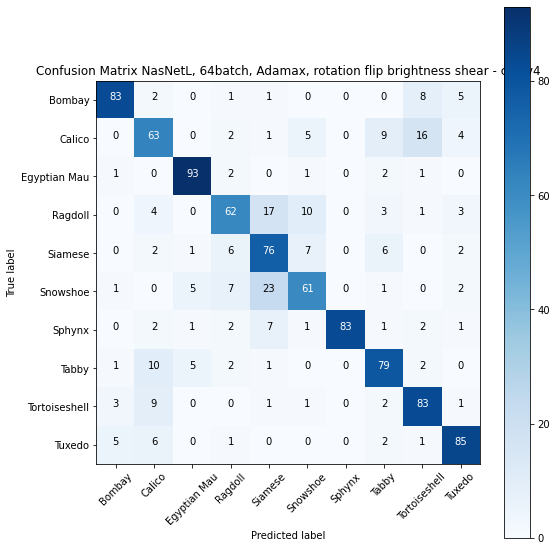

In [70]:
displayCM(y_true=test_batches.classes, predictions=pred_nl5, plot_labels=breeds, title=f'Confusion Matrix NasNetL, 64batch, Adamax, {augs} - catsv4')

# DO

In [ ]:
augs = 'brightness'

***

### Mobile


In [71]:
augs = ''

In [72]:
data_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.nasnet.preprocess_input, validation_split=0.3)
train_batches = data_gen.flow_from_directory(directory=train_dir, target_size=(INPUT_SIZE_M, INPUT_SIZE_M), classes=breeds, batch_size=64, subset="training") 
valid_batches = data_gen.flow_from_directory(directory=train_dir, target_size=(INPUT_SIZE_M, INPUT_SIZE_M), classes=breeds, batch_size=64, subset="validation")
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.nasnet.preprocess_input).flow_from_directory(directory=test_dir, target_size=(INPUT_SIZE_M, INPUT_SIZE_M), classes=breeds, batch_size=10, shuffle=False)

Found 18584 images belonging to 10 classes.
Found 7956 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [73]:
log_dir=os.path.join('logs','fitnm',curTime().strftime("%Y%m%d-%H%M%S"))

Current Time = 22:03:29


In [74]:
tb =  TensorBoard(log_dir=log_dir, histogram_freq=1,profile_batch = '500,520')

In [75]:
cbks=[tb,es]

In [76]:
nm1 = create_model_NasNetM(number_classes=no_classes, optimizer=optimizer, metrics=metrics)

19996672/19993432 [==============================] - 3s 0us/step


In [77]:
h_nm1 = nm1.fit(train_batches,epochs=100, callbacks=cbks,validation_data=valid_batches)

Epoch 1/100
165/291 [================>.............] - ETA: 2:45 - loss: 2.0346 - categorical_accuracy: 0.5872

KeyboardInterrupt: 

In [ ]:
plotLoss(f'NasNetM, 64batch, Adamax {augs} - catsv4', h_nm1)

In [ ]:
pred_nm1 = nm1.predict(x=test_batches, steps=len(test_batches), verbose=1)

In [ ]:
displayCM(y_true=test_batches.classes, predictions=pred_nm1, plot_labels=breeds, title=f'Confusion Matrix NasNetM, 64batch, Adamax {augs} - catsv4')

***

In [ ]:
augs = 'rotation flip'

In [ ]:
data_gen = ImageDataGenerator(horizontal_flip=True, rotation_range=90,preprocessing_function=tf.keras.applications.nasnet.preprocess_input, validation_split=0.3)
train_batches = data_gen.flow_from_directory(directory=train_dir, target_size=(INPUT_SIZE_M, INPUT_SIZE_M), classes=breeds, batch_size=64, subset="training") 
valid_batches = data_gen.flow_from_directory(directory=train_dir, target_size=(INPUT_SIZE_M, INPUT_SIZE_M), classes=breeds, batch_size=64, subset="validation")
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.nasnet.preprocess_input).flow_from_directory(directory=test_dir, target_size=(INPUT_SIZE_M, INPUT_SIZE_M), classes=breeds, batch_size=10, shuffle=False)

In [ ]:
log_dir=os.path.join('logs','fitnm',curTime().strftime("%Y%m%d-%H%M%S"))

In [ ]:
tb =  TensorBoard(log_dir=log_dir, histogram_freq=1,profile_batch = '500,520')

In [ ]:
cbks=[tb,es]

In [ ]:
nm2 = create_model_NasNetM(number_classes=no_classes, optimizer=optimizer, metrics=metrics)

In [ ]:
h_nm2 = nm2.fit(train_batches,epochs=100, callbacks=cbks,validation_data=valid_batches)

In [ ]:
plotLoss(f'NasNetM, 64batch, Adamax {augs} - catsv4', h_nm2)

In [ ]:
pred_nm2 = nm2.predict(x=test_batches, steps=len(test_batches), verbose=1)

In [ ]:
displayCM(y_true=test_batches.classes, predictions=pred_nm2, plot_labels=breeds, title=f'Confusion Matrix NasNetM, 64batch, Adamax, {augs} - catsv4')

***

In [ ]:
augs = 'rotation flip shear'

In [ ]:
data_gen = ImageDataGenerator(horizontal_flip=True, rotation_range=90,shear_range=40,preprocessing_function=tf.keras.applications.nasnet.preprocess_input, validation_split=0.3)
train_batches = data_gen.flow_from_directory(directory=train_dir, target_size=(INPUT_SIZE_M, INPUT_SIZE_M), classes=breeds, batch_size=64, subset="training") 
valid_batches = data_gen.flow_from_directory(directory=train_dir, target_size=(INPUT_SIZE_M, INPUT_SIZE_M), classes=breeds, batch_size=64, subset="validation")
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.nasnet.preprocess_input).flow_from_directory(directory=test_dir, target_size=(INPUT_SIZE_M, INPUT_SIZE_M), classes=breeds, batch_size=10, shuffle=False)

In [ ]:
log_dir=os.path.join('logs','fitnm',curTime().strftime("%Y%m%d-%H%M%S"))

In [ ]:
tb =  TensorBoard(log_dir=log_dir, histogram_freq=1,profile_batch = '500,520')

In [ ]:
cbks=[tb,es]

In [ ]:
nm3 = create_model_NasNetM(number_classes=no_classes, optimizer=optimizer, metrics=metrics)

In [ ]:
h_nm3 = nm3.fit(train_batches,epochs=100, callbacks=cbks,validation_data=valid_batches)

In [ ]:
plotLoss(f'NasNetM, 64batch, Adamax {augs} - catsv4', h_nm3)

In [ ]:
pred_nm3 = nm3.predict(x=test_batches, steps=len(test_batches), verbose=1)

In [ ]:
displayCM(y_true=test_batches.classes, predictions=pred_nm3, plot_labels=breeds, title=f'Confusion Matrix NasNetM, 64batch, Adamax, {augs} - catsv4')

***

In [ ]:
augs = 'rotation flip brightness'

In [ ]:
data_gen = ImageDataGenerator(horizontal_flip=True, rotation_range=90,brightness_range=[0.8,1.2],preprocessing_function=tf.keras.applications.nasnet.preprocess_input, validation_split=0.3)
train_batches = data_gen.flow_from_directory(directory=train_dir, target_size=(INPUT_SIZE_M, INPUT_SIZE_M), classes=breeds, batch_size=64, subset="training") 
valid_batches = data_gen.flow_from_directory(directory=train_dir, target_size=(INPUT_SIZE_M, INPUT_SIZE_M), classes=breeds, batch_size=64, subset="validation")
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.nasnet.preprocess_input).flow_from_directory(directory=test_dir, target_size=(INPUT_SIZE_M, INPUT_SIZE_M), classes=breeds, batch_size=10, shuffle=False)

In [ ]:
log_dir=os.path.join('logs','fitnm',curTime().strftime("%Y%m%d-%H%M%S"))

In [ ]:
tb =  TensorBoard(log_dir=log_dir, histogram_freq=1,profile_batch = '500,520')

In [ ]:
cbks=[tb,es]

In [ ]:
nm4 = create_model_NasNetM(number_classes=no_classes, optimizer=optimizer, metrics=metrics)

In [ ]:
h_nm4 = nm4.fit(train_batches,epochs=100, callbacks=cbks,validation_data=valid_batches)

In [ ]:
plotLoss(f'NasNetM, 64batch, Adamax {augs} - catsv4', h_nm4)

In [ ]:
pred_nm4 = nm4.predict(x=test_batches, steps=len(test_batches), verbose=1)

In [ ]:
displayCM(y_true=test_batches.classes, predictions=pred_nm4, plot_labels=breeds, title=f'Confusion Matrix NasNetM, 64batch, Adamax, {augs} - catsv4')

***

In [ ]:
augs = 'rotation flip brightness shear'

In [ ]:
data_gen = ImageDataGenerator(horizontal_flip=True, rotation_range=90,brightness_range=[0.8,1.2], shear_range=40,preprocessing_function=tf.keras.applications.nasnet.preprocess_input, validation_split=0.3)
train_batches = data_gen.flow_from_directory(directory=train_dir, target_size=(INPUT_SIZE_M, INPUT_SIZE_M), classes=breeds, batch_size=64, subset="training") 
valid_batches = data_gen.flow_from_directory(directory=train_dir, target_size=(INPUT_SIZE_M, INPUT_SIZE_M), classes=breeds, batch_size=64, subset="validation")
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.nasnet.preprocess_input).flow_from_directory(directory=test_dir, target_size=(INPUT_SIZE_M, INPUT_SIZE_M), classes=breeds, batch_size=10, shuffle=False)

In [ ]:
log_dir=os.path.join('logs','fitnm',curTime().strftime("%Y%m%d-%H%M%S"))

In [ ]:
tb =  TensorBoard(log_dir=log_dir, histogram_freq=1,profile_batch = '500,520')

In [ ]:
cbks=[tb,es]

In [ ]:
nm5 = create_model_NasNetM(number_classes=no_classes, optimizer=optimizer, metrics=metrics)

In [ ]:
h_nm5 = nm5.fit(train_batches,epochs=100, callbacks=cbks,validation_data=valid_batches)

In [ ]:
plotLoss(f'NasNetM, 64batch, Adamax {augs} - catsv4', h_nm5)

In [ ]:
pred_nm5 = nm5.predict(x=test_batches, steps=len(test_batches), verbose=1)

In [ ]:
displayCM(y_true=test_batches.classes, predictions=pred_nm5, plot_labels=breeds, title=f'Confusion Matrix NasNetM, 64batch, Adamax, {augs} - catsv4')